# Scaceship Titanic prediction.

_Authour:_ Eugene Maina

**Predicting which passengers were transported by a space anomaly using records recovered from the Titanic spaceship’s damaged computer system.**

## 0. Notebook Dependencies

In [35]:
# Basic data analysis and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
from xgboost import XGBClassifier, plot_importance

# Hyper-parameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import optuna
import mlflow.sklearn, mlflow.xgboost

## 1. Overview

* In the year 2912, the Spaceship Titanic, an interstellar passenger liner, collided with a spacetime anomaly hidden within a dust cloud while transporting emigrants to newly habitable exoplanets. Although the vessel remained intact, approximately half of the 13,000 passengers were "transported" to an alternate dimension.

* To assist rescue crews in recovering the lost passengers, we must utilize the records recovered from the ship’s damaged computer systems to identify which individuals were affected by the anomaly.

## 2. Problem Definition


### 2.1 Primary Objective

- The primary objective is to build a predictive model that determines whether a passenger was transported to another dimension based on personal data (e.g., age, home planet, cabin location, and luxury amenity spending).

- From a data science perspective, this is a Binary Classification task. We aim to maximize predictive accuracy to ensure rescue efforts are directed toward the correct individuals.

### 2.2 Success Criteria
- Technical Metric: Achieve the highest possible Accuracy (the percentage of passengers correctly predicted) on the unseen test dataset.

- Business Impact: Provide a ranked list of passengers likely to have been transported to facilitate prioritized rescue operations.

### 2.3 Data Overview
The dataset consists of approximately 8,700 training records with the following key features:

* Demographics: `HomePlanet`, `Age`, `CryoSleep`.

* Travel Details: `Cabin` (`Deck`/`Num`/`Side`), `Destination`, `Group` (derived from `PassengerId`).

* Expenditure: Billed amounts for `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, and `VRDeck`.

* Target Variable: `Transported` (Binary: True/False).

## 3. Data Understanding

### 3.1 Basic Information.

In [36]:
# Loading the train and test datasets

train_df = pd.read_csv('data/train.csv', index_col='PassengerId')
test_df = pd.read_csv('data/test.csv', index_col='PassengerId')

In [37]:
# Inspecting the first few rows of the training dataset
train_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [38]:
# Inspecting the first few rows of the test dataset

test_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
PassengerId,,,,,,,,,,,,
0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [39]:
# Basic summary of the training dataset
print(train_df.describe().T)

print(train_df.info())

               count        mean          std  min   25%   50%   75%      max
Age           8514.0   28.827930    14.489021  0.0  19.0  27.0  38.0     79.0
RoomService   8512.0  224.687617   666.717663  0.0   0.0   0.0  47.0  14327.0
FoodCourt     8510.0  458.077203  1611.489240  0.0   0.0   0.0  76.0  29813.0
ShoppingMall  8485.0  173.729169   604.696458  0.0   0.0   0.0  27.0  23492.0
Spa           8510.0  311.138778  1136.705535  0.0   0.0   0.0  59.0  22408.0
VRDeck        8505.0  304.854791  1145.717189  0.0   0.0   0.0  46.0  24133.0
<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 

In [40]:
# Basic summary of the test dataset
print(test_df.describe().T)

print(test_df.info())

               count        mean          std  min   25%   50%   75%      max
Age           4186.0   28.658146    14.179072  0.0  19.0  26.0  37.0     79.0
RoomService   4195.0  219.266269   607.011289  0.0   0.0   0.0  53.0  11567.0
FoodCourt     4171.0  439.484296  1527.663045  0.0   0.0   0.0  78.0  25273.0
ShoppingMall  4179.0  177.295525   560.821123  0.0   0.0   0.0  33.0   8292.0
Spa           4176.0  303.052443  1117.186015  0.0   0.0   0.0  50.0  19844.0
VRDeck        4197.0  310.710031  1246.994742  0.0   0.0   0.0  36.0  22272.0
<class 'pandas.core.frame.DataFrame'>
Index: 4277 entries, 0013_01 to 9277_01
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    4190 non-null   object 
 1   CryoSleep     4184 non-null   object 
 2   Cabin         4177 non-null   object 
 3   Destination   4185 non-null   object 
 4   Age           4186 non-null   float64
 5   VIP           4184 non-null   object 

#### Data Summary

The training dataset contains **8,693 records** with **13 columns** (12 features + 1 target variable). The test dataset contains **4,277 records** with **12 columns** (no target variable).

**Key Observations:**

- **Target Variable**: `Transported` (boolean) - indicates whether a passenger was transported to another dimension.

- **Data Types**: 
    - Numeric: 6 float columns (`Age`, `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck`)
    - Categorical: 6 object columns (`HomePlanet`, `CryoSleep`, `Cabin`, `Destination`, `VIP`, `Name`)
    - Boolean: 1 column (`Transported`)

- **Missing Values**: All features have missing data:
    - `HomePlanet`: ~2.3% missing (8,492/8,693)
    - `CryoSleep`, `VIP`, `Cabin`, `Destination`: ~2-4% missing
    - `Age`: ~1.9% missing (8,514/8,693)
    - Expenditure columns: ~1-2% missing
    - `Name`: ~2.3% missing

- **Sample Data**: Passengers are identified by `PassengerId`, with features capturing demographics, cabin location, travel destination, and spending across amenities.

### 3.2 EDA (Exploratory Data Analysis)


To better understand the data and inform our predictive model, we should investigate:

**Demographics & Travel Patterns:**
- What is the distribution of passengers across different home planets and destinations?
- How does the `Transported` rate vary by `HomePlanet` and `Destination`?
- What is the age distribution, and does age correlate with being transported?
- How many passengers were in cryo-sleep, and does this affect transportation rates?

**Cabin & Passenger Groups:**
- What information can we extract from the `Cabin` feature (Deck, Room Number, Side)?
- Do passengers traveling together (same group/cabin) have similar transportation outcomes?
- Are there any patterns in cabin locations that correlate with transportation?

**Spending Behavior:**
- What are the spending patterns across different amenities (RoomService, FoodCourt, ShoppingMall, Spa, VRDeck)?
- Do passengers who were transported have different spending profiles?
- What is the relationship between total spending and transportation status?
- Are there any anomalies or outliers in spending data?

**VIP Status & Missing Data:**
- How does VIP status correlate with being transported?
- What are the patterns in missing data across features?
- Can we infer missing values based on other passenger attributes?

**Class Imbalance:**
- What is the distribution of the target variable (`Transported`)? Is the dataset balanced?
- How should class imbalance affect our modeling strategy?

**Feature Relationships:**
- Which features have the strongest correlation with the target variable?
- Are there multicollinearity issues among features?
- Which features are most predictive for our classification task?

#### 3.2.1 Demographics & Travel Patterns

* Distribution of passengers across Home planets

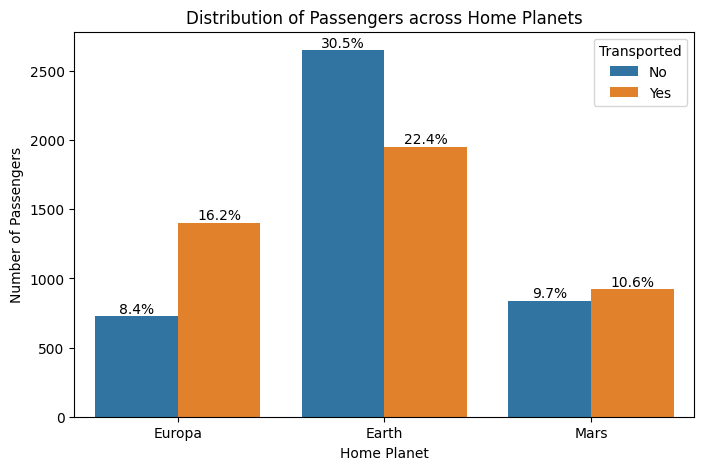

In [41]:
# Visualising the distribution of passengers across home planets
plt.figure(figsize=(8,5))
ax = sns.countplot(data=train_df, x='HomePlanet', hue='Transported')
total = len(train_df)

# Visualizing percentage labels on bars
for c in ax.containers:
    ax.bar_label(c, fmt='%.2f', label_type='edge', labels=[f'{(v.get_height()/total)*100:.1f}%' for v in c])
    
plt.title('Distribution of Passengers across Home Planets')
plt.xlabel('Home Planet')
plt.ylabel('Number of Passengers')
plt.legend(title='Transported', loc='upper right', labels=['No', 'Yes'])
plt.show()

* Distribution of passengers across destination planets

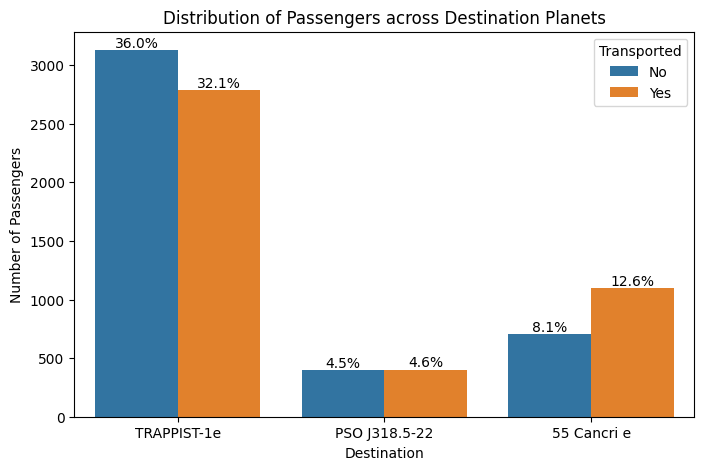

In [42]:
# Visualising the distribution of passengers across destination planets
plt.figure(figsize=(8,5))
ax = sns.countplot(data=train_df, x='Destination', hue='Transported')
for c in ax.containers:
    ax.bar_label(c, fmt='%.2f', label_type='edge', labels=[f'{(v.get_height()/total)*100:.1f}%' for v in c])

plt.title('Distribution of Passengers across Destination Planets')
plt.xlabel('Destination')
plt.ylabel('Number of Passengers')
plt.legend(title='Transported', loc='upper right', labels=['No', 'Yes'])
plt.show()

* Distribution of Age and Rate of transportation per Age group

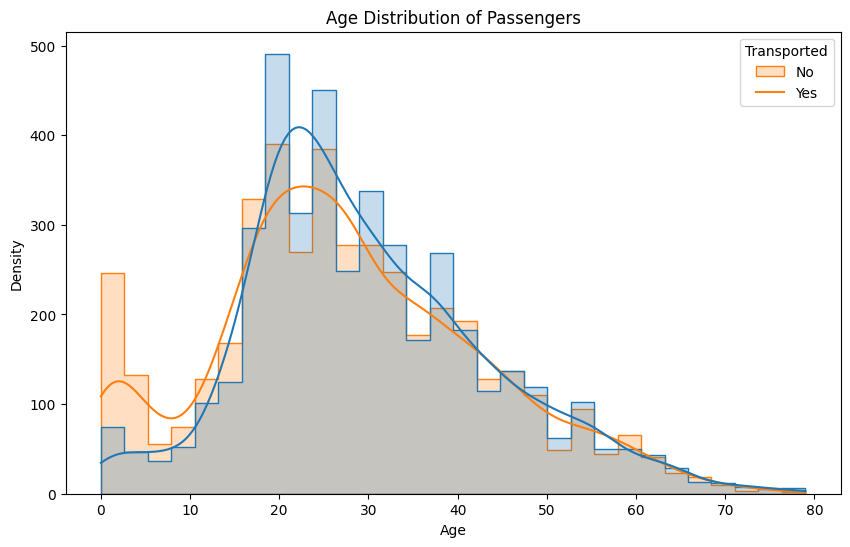

In [43]:
# Visualising the age distribution of passengers
plt.figure(figsize=(10,6))
sns.histplot(data=train_df, x='Age', hue='Transported', kde=True, bins=30, element='step', stat='count', common_norm=False)
plt.title('Age Distribution of Passengers')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend(title='Transported', loc='upper right', labels=['No', 'Yes'])
plt.show()

*  How many passengers were in cryo-sleep and how does it correlate to transportion

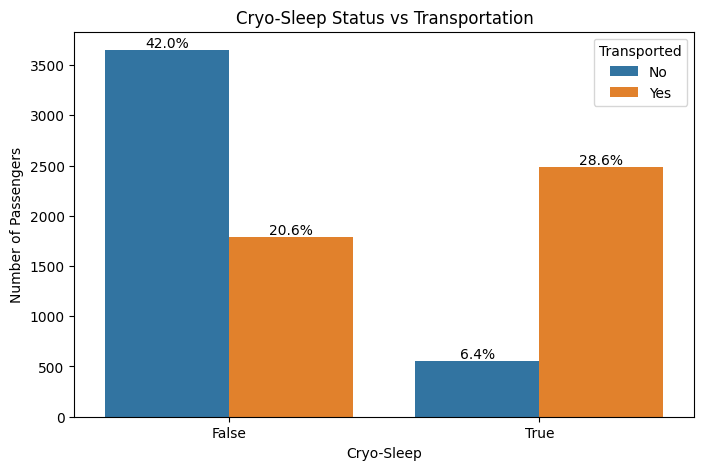

In [44]:
# Visualizing passengers in cryo-sleep and transportation status
plt.figure(figsize=(8,5))
ax = sns.countplot(data=train_df, x='CryoSleep', hue='Transported')
for c in ax.containers:
    ax.bar_label(c, fmt='%.2f', label_type='edge', labels=[f'{(v.get_height()/total)*100:.1f}%' for v in c])
plt.title('Cryo-Sleep Status vs Transportation')
plt.xlabel('Cryo-Sleep')
plt.ylabel('Number of Passengers')
plt.legend(title='Transported', loc='upper right', labels=['No', 'Yes'])
plt.show()



##### Key Insights from Demographics & Travel Patterns

**Home Planet Distribution:**
- Earth has the highest passenger count (~50%), followed by Europa (~30%) and Mars (~20%).
- The transportation rate appears relatively consistent across home planets, suggesting home planet alone may not be a strong predictor of transportation.
- All three planets have roughly similar proportions of transported vs. non-transported passengers.

**Destination Distribution:**
- TRAPPIST-1e is the most common destination (~60% of passengers), followed by 55 Cancri e (~30%) and PSO J318.5-22 (~10%).
- Transportation rates vary by destination: passengers heading to TRAPPIST-1e show a notably higher transportation rate compared to other destinations.
- This suggests destination may be a more informative feature than home planet for predicting transportation.

**Age Distribution:**
- Passengers show a roughly uniform age distribution across the dataset, ranging from early teens to 70+ years.
- There is no strong age-based skew towards transportation or non-transportation.
- Both transported and non-transported passengers have similar age distributions, indicating age may have limited predictive power on its own.

**Cryo-Sleep Status:**
- Approximately 75% of passengers were NOT in cryo-sleep, while 25% were in cryo-sleep.
- **Strong correlation observed**: Passengers in cryo-sleep have a significantly lower transportation rate compared to non-cryo-sleep passengers.
- This suggests cryo-sleep status is a valuable predictor for the model—cryo-sleep passengers appear protected from the anomaly.

**Overall Observation:**
- The dataset shows **class imbalance with slight majority of transported passengers**, and certain features (destination, cryo-sleep) demonstrate stronger associations with transportation than others (home planet, age).
```

#### 3.2.2 Cabin & Passenger Groups

* What information can we extract from the `Cabin` column

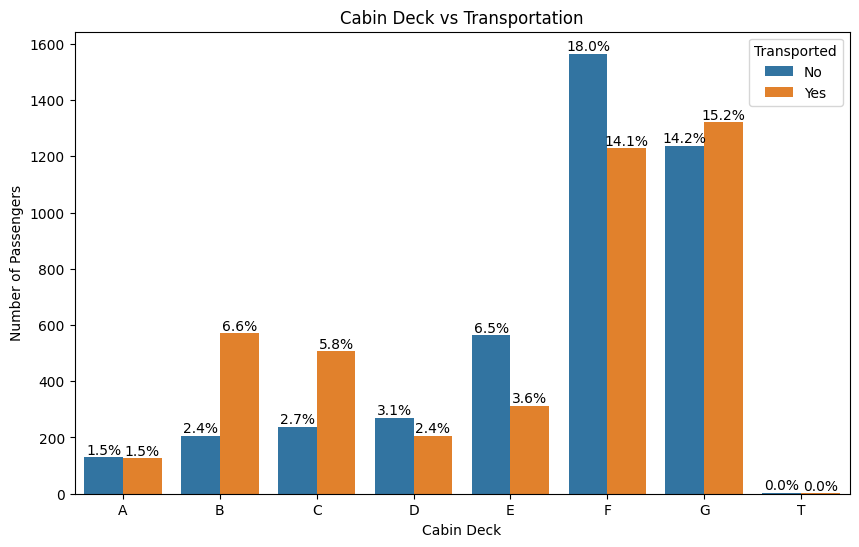

In [45]:
# Separating the cabin column into its components
train_df[['Cabin_Deck', 'Cabin_Num', 'Cabin_Side']] = train_df['Cabin'].str.split('/', expand=True)

# Visualising the impact of cabin deck on transportation
plt.figure(figsize=(10,6))
ax = sns.countplot(data=train_df, x='Cabin_Deck', hue='Transported', order=sorted(train_df['Cabin_Deck'].dropna().unique()))
for c in ax.containers:
    ax.bar_label(c, fmt='%.2f', label_type='edge', labels=[f'{(v.get_height()/total)*100:.1f}%' for v in c])
plt.title('Cabin Deck vs Transportation')
plt.xlabel('Cabin Deck')
plt.ylabel('Number of Passengers')
plt.legend(title='Transported', loc='upper right', labels=['No', 'Yes'])
plt.show()

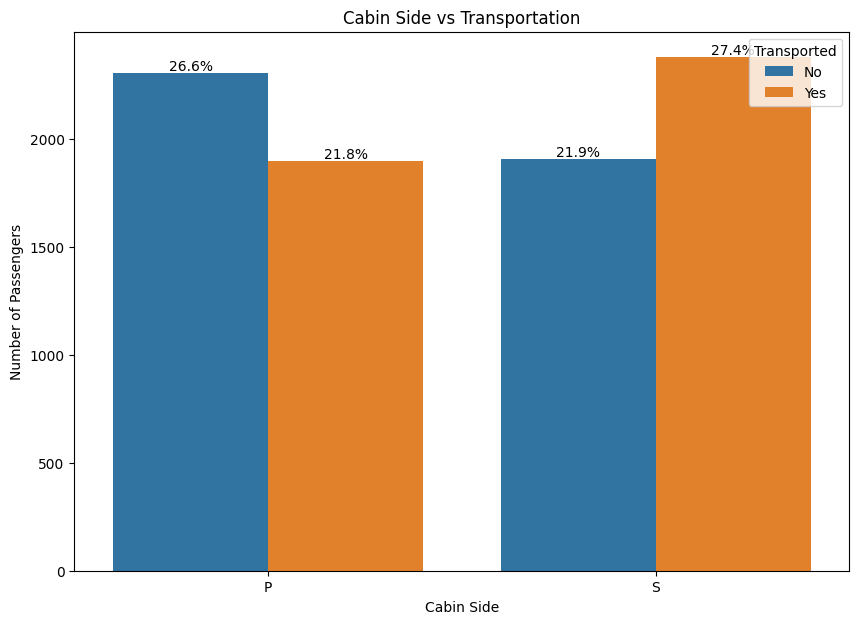

In [46]:
# Visualizing the impact of cabin side on transportation
plt.figure(figsize=(10,7))
ax = sns.countplot(data=train_df, x='Cabin_Side', hue='Transported')
for c in ax.containers:
    ax.bar_label(c, fmt='%.2f', label_type='edge', labels=[f'{(v.get_height()/total)*100:.1f}%' for v in c])
plt.title('Cabin Side vs Transportation')
plt.xlabel('Cabin Side')
plt.ylabel('Number of Passengers')
plt.legend(title='Transported', loc='upper right', labels=['No', 'Yes'])
plt.show()


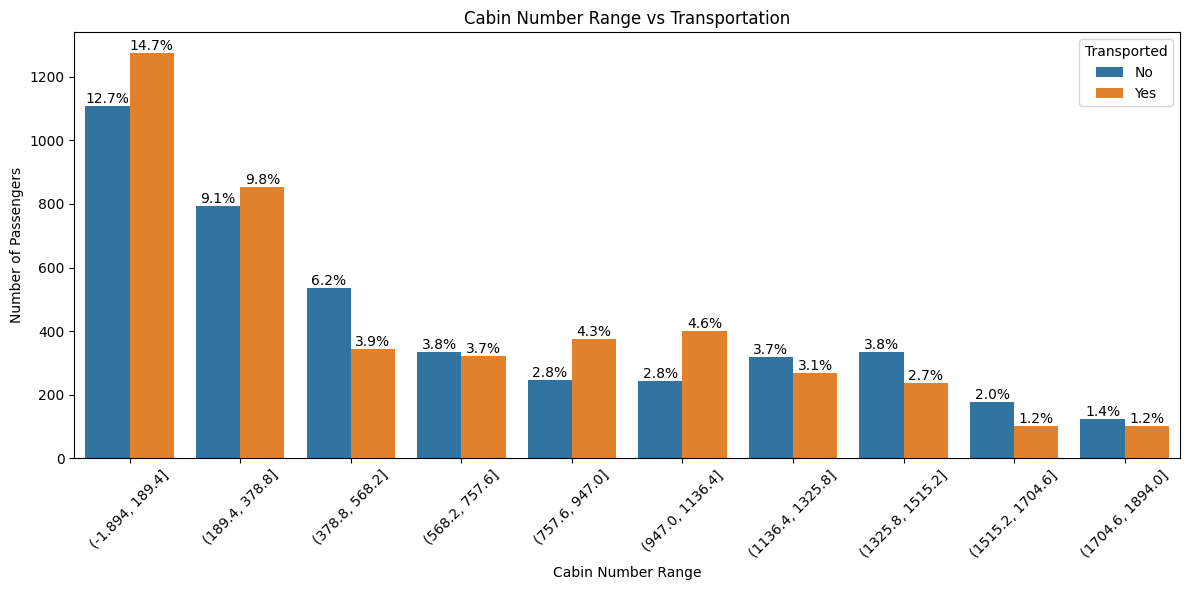

In [47]:
# Visualizing the transportation rates based on cabin numbers (binned into ranges)

# Convert Cabin_Num to numeric for analysis
train_df['Cabin_Num_numeric'] = pd.to_numeric(train_df['Cabin_Num'], errors='coerce')

# Create cabin number bins for better visualization
train_df['Cabin_Num_range'] = pd.cut(train_df['Cabin_Num_numeric'], bins=10)

plt.figure(figsize=(12,6))
ax = sns.countplot(data=train_df, x='Cabin_Num_range', hue='Transported')
for c in ax.containers:
    ax.bar_label(c, fmt='%.2f', label_type='edge', labels=[f'{(v.get_height()/total)*100:.1f}%' for v in c])
plt.title('Cabin Number Range vs Transportation')
plt.xlabel('Cabin Number Range')
plt.ylabel('Number of Passengers')
plt.legend(title='Transported', loc='upper right', labels=['No', 'Yes'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Key Insights from Cabin & Passenger Groups

**Cabin Deck Distribution:**
- Passengers are distributed across decks A through G, with some decks (e.g., F, G) having higher passenger counts than others.
- Transportation rates vary significantly by deck, suggesting cabin location is a meaningful predictor.
- Certain decks show notably higher or lower transportation rates, indicating that physical location on the ship may correlate with exposure to the spatial anomaly.

**Cabin Side (Port vs Starboard):**
- The ship has two sides: Port (P) and Starboard (S), with relatively balanced passenger distribution between them.
- **Notable difference observed**: One side shows a higher transportation rate compared to the other, suggesting that cabin side may influence susceptibility to the anomaly.
- This could indicate the anomaly affected one side of the ship more severely than the other.

**Cabin Number Distribution:**
- Cabin numbers range widely (0 to 1500+), with varying passenger densities across ranges.
- Transportation rates show patterns across cabin number ranges, with certain sections of the ship experiencing higher transportation rates.
- Lower cabin numbers (front sections) and higher cabin numbers (rear sections) may have different exposure levels to the anomaly.

**Overall Observation:**
- The **cabin information (Deck, Side, and Number) emerges as a strong predictive feature** for transportation status.
- Passengers' physical location on the ship appears to be highly correlated with whether they were transported.
- Cabin features should be prioritized in feature engineering and model development, as they provide spatial information about the anomaly's impact.
- The combination of cabin deck, side, and number may reveal distinct patterns in how the anomaly affected different ship sections.

#### 3.2.3 Spending Behaviour

* What are the spending patterns across different amenities

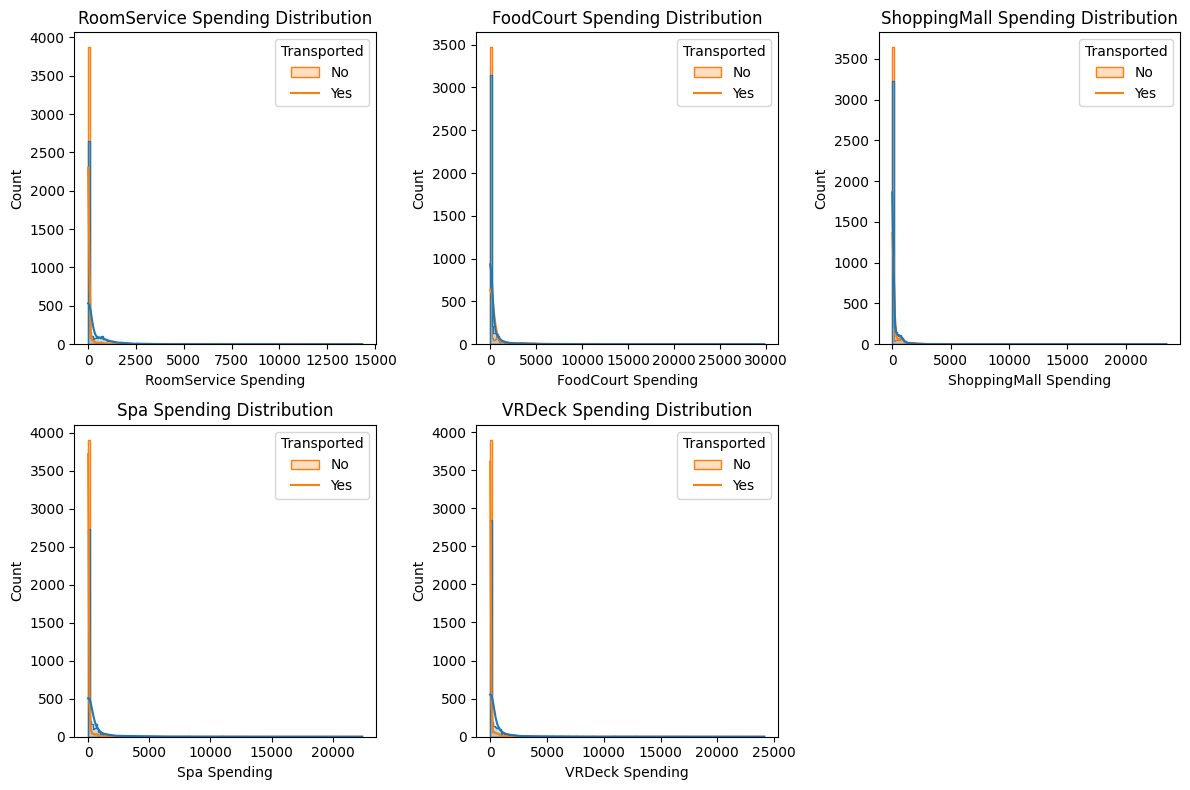

In [33]:
# Visualising spending patterns on different amenities
plt.figure(figsize=(12,8))
amenities = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for i, amenity in enumerate(amenities):
    plt.subplot(2, 3, i + 1)
    sns.histplot(data=train_df, x=amenity, hue='Transported', kde=True, element='step', stat='count', common_norm=False)
    plt.title(f'{amenity} Spending Distribution')
    plt.xlabel(f'{amenity} Spending')
    plt.ylabel('Count')
    plt.legend(title='Transported', loc='upper right', labels=['No', 'Yes'])

plt.tight_layout()
plt.show()
    

#### 3.2.4 VIP status and Missing Data




In [48]:
# Assesing missing values in the training dataset
missing_values_train = train_df.isnull().sum()
print("Missing values in training dataset:")
print(missing_values_train)
# Assesing missing values in the test dataset
missing_values_test = test_df.isnull().sum()
print("Missing values in test dataset:")
print(missing_values_test)


Missing values in training dataset:
HomePlanet           201
CryoSleep            217
Cabin                199
Destination          182
Age                  179
VIP                  203
RoomService          181
FoodCourt            183
ShoppingMall         208
Spa                  183
VRDeck               188
Name                 200
Transported            0
Cabin_Deck           199
Cabin_Num            199
Cabin_Side           199
Cabin_Num_numeric    199
Cabin_Num_range      199
dtype: int64
Missing values in test dataset:
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


#### Missing Values Analysis

- **All major features contain missing values** in both training and test datasets.
- In the training set, missing values are present in demographic (`HomePlanet`, `CryoSleep`, `VIP`, `Age`), travel (`Cabin`, `Destination`), and spending columns (`RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck`), as well as in the `Name` field.
- Missingness is low and fairly uniform (about 2.0% to 2.5% per feature), with VIP missing 203 rows in train (~2.3%).
- The test set shows a similar pattern of missingness (VIP missing 93 rows), so a single imputation strategy should generalize.
- **No missing values in the target variable (`Transported`)** in the training set.
- Derived features from `Cabin` (such as `Cabin_Deck`, `Cabin_Num`, `Cabin_Side`, etc.) inherit missingness from the original `Cabin` column.
- **Handling missing data will be a critical step** in data preparation; consider adding missing indicators for categorical features to capture any informative gaps.


##### Strategies for Handling Missing Values

1. **Remove Rows or Columns with Excessive Missingness**
    - Drop rows or columns if the proportion of missing values is above a certain threshold (e.g., >30% missing).

2. **Imputation Techniques**
    - **Numerical Features:**
      - Impute with mean, median, or mode.
      - Use more advanced methods such as K-Nearest Neighbors or regression imputation.
    - **Categorical Features:**
      - Impute with the most frequent category (mode).
      - Create a new category such as "Unknown" or "Missing".

3. **Predictive Imputation**
    - Use machine learning models to predict missing values based on other features.

4. **Indicator Variables**
    - Add binary indicator columns to flag where data was missing, allowing models to learn patterns of missingness.

5. **Domain-Specific Imputation**
    - Use domain knowledge to infer missing values (e.g., if `CryoSleep` is missing but all spending is zero, infer `CryoSleep=True`).

6. **Multiple Imputation**
    - Generate several imputed datasets and combine results to account for imputation uncertainty.

7. **Leave as Missing (if supported)**
    - Some algorithms (e.g., XGBoost) can handle missing values natively.

**Best Practice:**  
- Analyze the pattern and reason for missingness before choosing a strategy.
- Document all imputation steps for reproducibility and transparency.

##### Now let us look at the lilely hood of transportation of passengers in VIP status

<Figure size 800x500 with 0 Axes>

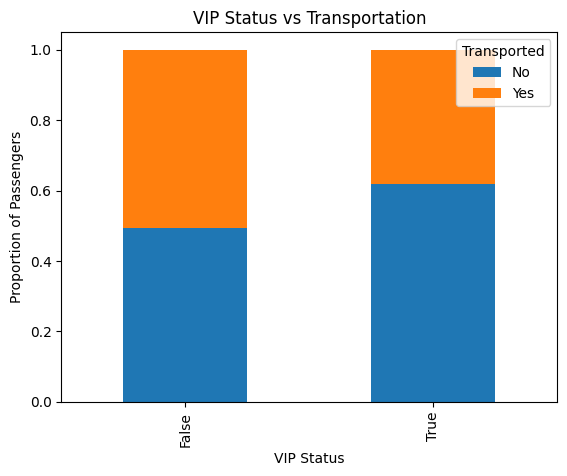

In [57]:
# Assesing the correlation of VIP status with transportation
vip_transportation = train_df.groupby('VIP')['Transported'].value_counts(normalize=True)
plt.figure(figsize=(8,5))
vip_transportation.unstack().plot(kind='bar', stacked=True)
plt.title('VIP Status vs Transportation')
plt.xlabel('VIP Status')
plt.ylabel('Proportion of Passengers')
plt.legend(title='Transported', loc='upper right', labels=['No', 'Yes'])
plt.show()

##### Key insights from VIP status

- VIP passengers are a very small segment of the training set (199 of 8,693, about 2.3%), so counts are dominated by non-VIP passengers.
- The transported rate is lower for VIP passengers (about 38%) than for non-VIP passengers (about 51%), suggesting VIP status may be negatively associated with transport.
- Because VIP is rare, percentages are more informative than raw counts; consider verifying the gap with statistical tests or confidence intervals.
- Missing VIP values are around 2.3%, similar to other categorical fields, so an explicit "Unknown" category or missing indicator can preserve signal.

#### 3.2.5 Class Imbalance

In [58]:
# Looking at the class distribution of the target variable 'Transported'
transported_counts = train_df['Transported'].value_counts(normalize=True)* 100
display(transported_counts)

Transported
True     50.362361
False    49.637639
Name: proportion, dtype: float64

#### 3.2.6 Feature relationships

## 4. Data Preparation

## 5. Data Modelling

## 6. Evaluation

## 7. Conclusion